# Set up

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Performing PCA with an Undercomplete Linear Autoencoder

In [5]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

2024-04-05 22:53:52.682199: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Now, we generate the same 3D dataset we used in chapter 8.

In [6]:
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.randn(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 + np.random.randn(m, 3)  # add more noises
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [7]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=0)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 1ms/step


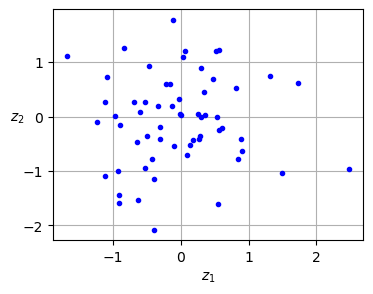

In [11]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.grid()